In [1]:
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 10

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)


def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "MNIST",
            # 'dataset': "FashionMNIST",
            'random_class_idx': False,

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 5,
            'per_task_examples': np.inf,
            # 'per_task_examples': 10000,
            'per_task_memory_examples': 64,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 1.,
            # 'tau': 0.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            'device': torch.device('cuda:7' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha':0.001,
            'lambda': .0,
            'lambda_old': 0.0,
              }

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_alpha={params['alpha']}_tau={params['tau']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=MNIST/seed=10_epoch=5_lr=0.001_alpha=0.001_tau=1.0


In [2]:
from datasets import MNIST
from datasets import FashionMNIST
from datasets import CIFAR10, CIFAR100

if params['dataset'] == 'MNIST':
    benchmark = MNIST(num_tasks=params['num_tasks'],
                    per_task_memory_examples=params['per_task_memory_examples'],
                    per_task_examples = params['per_task_examples'],
                    random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'FashionMNIST':
    benchmark = FashionMNIST(num_tasks=params['num_tasks'],
                            per_task_memory_examples=params['per_task_memory_examples'],
                            per_task_examples = params['per_task_examples'],
                            random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'CIFAR10':
    benchmark = CIFAR10(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
elif params['dataset'] == 'CIFAR100':        
    benchmark = CIFAR100(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
else:
    raise NotImplementedError
class_idx = benchmark.class_idx
num_classes = len(class_idx)



[0 1 2 3 4 5 6 7 8 9]


In [3]:
from algorithms.imbalance import Heuristic2
from metrics import MetricCollector2
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
algorithm = Heuristic2(backbone, benchmark, params, requires_memory=True)
metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])

In [4]:
# from trainers import ContinualTrainer
# from trainers.fair_trainer import FairContinualTrainer2 as ContinualTrainer
from trainers.imbalance_trainer import ImbalanceContinualTrainer1 as ContinualTrainer

trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 5.093206283823536e-05, 'std': 0.0010204081632653184, 'EER': -1}
[2] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 2.9797873065650604e-05, 'std': 0.0010204081632653184, 'EER': -1}
[3] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.974790957018768e-05, 'std': 0.0010204081632653184, 'EER': -1}
[4] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.5865623109905715e-05, 'std': 0.0010204081632653184, 'EER': -1}
[5] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.355548640801164e-05, 'std': 0.0010204081632653184, 'EER': -1}
training_task_end
---------------------------- Task 2 -----------------------
Elapsed time(grad):12.183
losses=tensor([[3.2053e-04, 1.4590e-03, 9.3039e+00, 9.3235e+00]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):8.406
Fairne

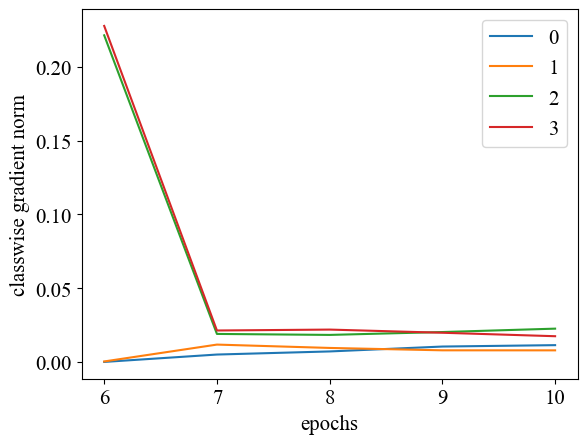

---------------------------- Task 3 -----------------------
Elapsed time(grad):13.166
losses=tensor([[0.0480, 0.0518, 0.0562, 0.0887, 7.9708, 9.2368]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):10.445
Fairness:[ 0.41823797  0.37503108  0.02680748  0.         -0.24688878 -0.57318775]
Current class expected loss:[0. 0. 0. 0. 0. 0.]
len(updated_seq_indices)=10368
[11] Eval metrics for task 1 >> {'accuracy': 0.9282275465252181, 'loss': 0.0009891825364836565, 'std': 0.03741121999460578, 'EER': -1}
[11] Eval metrics for task 2 >> {'accuracy': 0.8321398418911659, 'loss': 0.001961695006615268, 'std': 0.010434415534576691, 'EER': -1}
[11] Eval metrics for task 3 >> {'accuracy': 0.9522047071502288, 'loss': 0.0006625427603085496, 'std': 0.039648653338569595, 'EER': -1}
Elapsed time(grad):6.246
losses=tensor([[0.0485, 0.0479, 0.0577, 0.1256, 0.0870, 0.2599]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):11.292
Fairness:[ 0.          

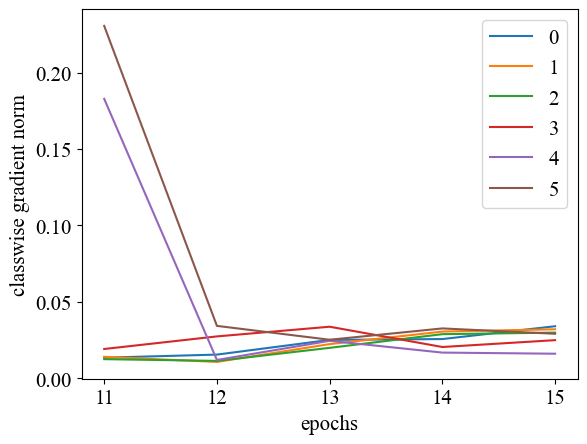

---------------------------- Task 4 -----------------------
Elapsed time(grad):14.698
losses=tensor([[0.1609, 0.1513, 0.1592, 0.1768, 0.1465, 0.1331, 9.3610, 8.7428]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):16.083
Fairness:[ 0.17424619  0.24301329  0.25342002  0.19185607 -0.15530395  0.
 -0.42935071 -0.27788103]
Current class expected loss:[0. 0. 0. 0. 0. 0. 0. 0.]
len(updated_seq_indices)=10240
[16] Eval metrics for task 1 >> {'accuracy': 0.9374112199946059, 'loss': 0.0009798747287010751, 'std': 0.028227546525218028, 'EER': -1}
[16] Eval metrics for task 2 >> {'accuracy': 0.8074938598511014, 'loss': 0.002632567190166552, 'std': 0.0410209916340471, 'EER': -1}
[16] Eval metrics for task 3 >> {'accuracy': 0.8612936443425607, 'loss': 0.001799690907894611, 'std': 0.010396783356013628, 'EER': -1}
[16] Eval metrics for task 4 >> {'accuracy': 0.9496448096309594, 'loss': 0.0007089174316008645, 'std': 0.014362972470207902, 'EER': -1}
Elapsed time(grad):10.82

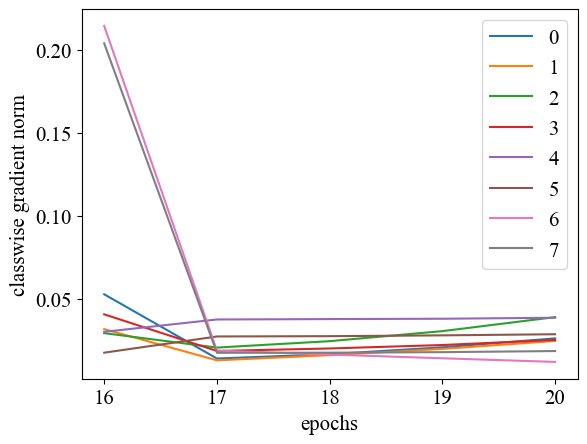

---------------------------- Task 5 -----------------------
Elapsed time(grad):13.317
losses=tensor([[0.1497, 0.1979, 0.2164, 0.1596, 0.2324, 0.2395, 0.0469, 0.0422, 8.1972,
         9.6396]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):20.962
Fairness:[ 0.13106065  0.15648578  0.1277805   0.12071274  0.06268186  0.05308213
  0.01293013 -0.10014335 -0.23372648 -0.33086414]
Current class expected loss:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
len(updated_seq_indices)=11800
[21] Eval metrics for task 1 >> {'accuracy': 0.9216218646048728, 'loss': 0.0011677937586538616, 'std': 0.011417782972219681, 'EER': -1}
[21] Eval metrics for task 2 >> {'accuracy': 0.7338485302018574, 'loss': 0.003596098194159677, 'std': 0.023577212372400014, 'EER': -1}
[21] Eval metrics for task 3 >> {'accuracy': 0.7298229110536747, 'loss': 0.0031253200584949016, 'std': 0.014576274282374235, 'EER': -1}
[21] Eval metrics for task 4 >> {'accuracy': 0.8059754839443394, 'loss': 0.002441270909040476,

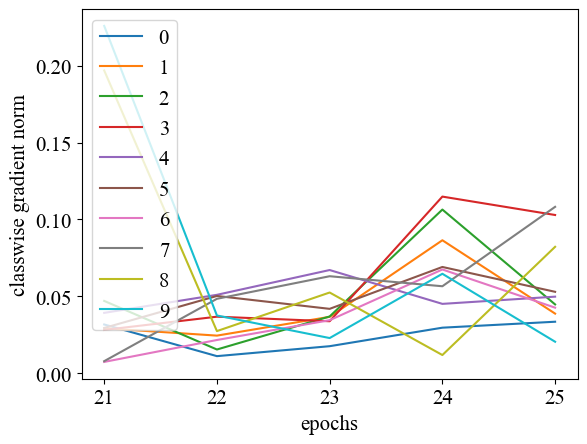

final avg-acc 0.8131551862629738
final avg-forget 0.17996056624119788


In [5]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [6]:
metric_manager_callback.meters['accuracy'].get_data()

array([[0.999, 0.   , 0.   , 0.   , 0.   ],
       [0.941, 0.965, 0.   , 0.   , 0.   ],
       [0.848, 0.758, 0.971, 0.   , 0.   ],
       [0.89 , 0.751, 0.849, 0.963, 0.   ],
       [0.862, 0.672, 0.831, 0.812, 0.889]])

In [7]:
np.mean(metric_manager_callback.meters['accuracy'].compute_overall())

0.8974621588150024

In [8]:
[np.round(x, 3) for x in metric_manager_callback.meters['EER'].compute_overall()]

[0.0, 0.012, 0.074, 0.063, 0.057]

In [9]:
np.mean(metric_manager_callback.meters['EER'].compute_overall())

0.041202425691648614

In [10]:
[np.round(x, 3) for x in metric_manager_callback.meters['std'].compute_overall()]

[0.001, 0.026, 0.099, 0.086, 0.094]

In [11]:
np.mean(metric_manager_callback.meters['std'].compute_overall())

0.06140973358367172

In [12]:
print(f"accuracy:{np.mean(metric_manager_callback.meters['accuracy'].compute_overall())}")
print(f"EER:{np.mean(metric_manager_callback.meters['EER'].compute_overall())}")
print(f"std:{np.mean(metric_manager_callback.meters['std'].compute_overall())}")


accuracy:0.8974621588150024
EER:0.041202425691648614
std:0.06140973358367172
